In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam

# Download UTKFace dataset using KaggleHub
import kagglehub
jangedoo_utkface_new_path = kagglehub.dataset_download('jangedoo/utkface-new')
print('Data source import complete.')

# Correct the path to where the dataset was downloaded
image_folder_path = os.path.join(jangedoo_utkface_new_path, "crop_part1")

# Load images, ages, and genders
images = []
ages = []
genders = []

# Load data
for i in os.listdir(image_folder_path)[0:8000]:  # Limit to first 8000 images for now
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    img = Image.open(os.path.join(image_folder_path, i))
    img = img.resize((128, 128))  # Resize to 128x128 for easier processing
    img_array = img_to_array(img)
    images.append(img_array)

# Convert lists to numpy arrays
images = np.array(images)
ages = np.array(ages)
genders = np.array(genders)

# Normalize image data
images = images / 255.0  # Normalize images to the range [0, 1]

# Set up the DataFrame for insights
df = pd.DataFrame({'Age': ages, 'Gender': genders})



100%|██████████| 331M/331M [00:01<00:00, 230MB/s]

Extracting files...


Data source import complete.


<ipython-input-2-d2ca728500d1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=genders, palette='pastel')


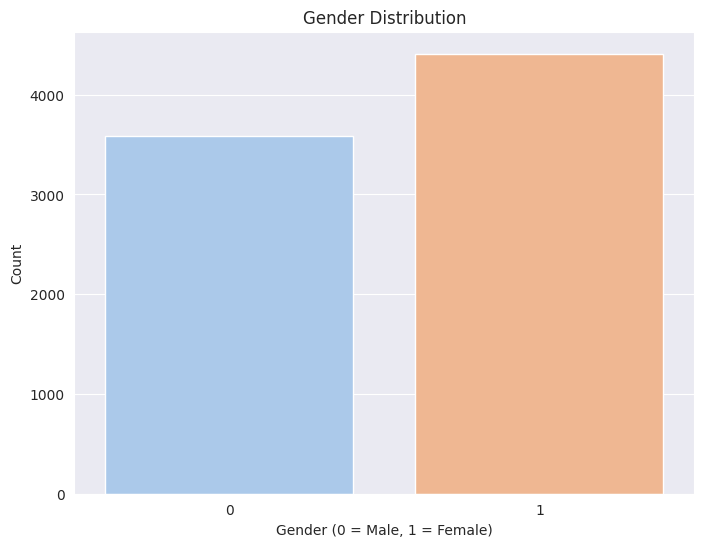

<ipython-input-2-d2ca728500d1>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=age_groups, palette='coolwarm')


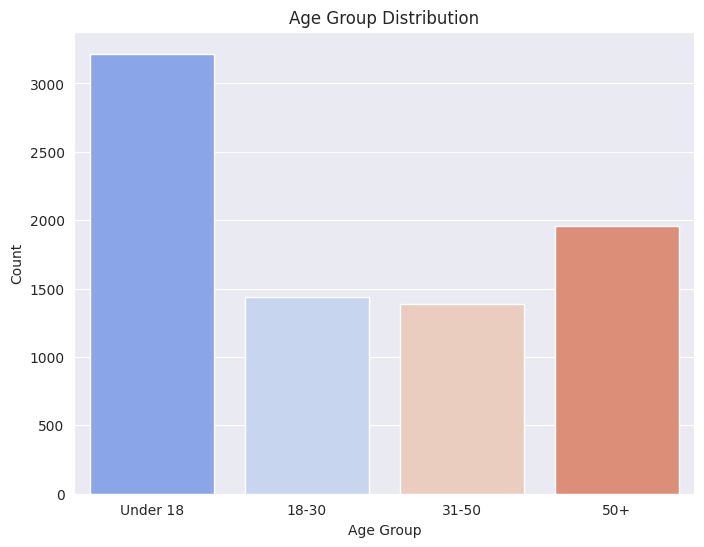

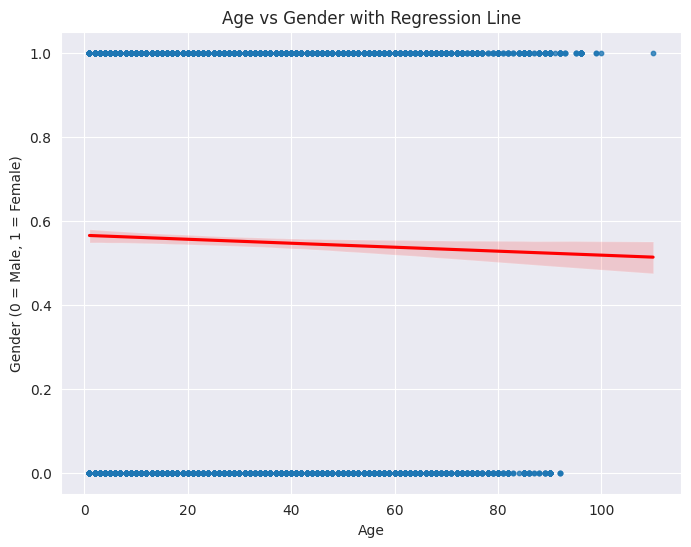

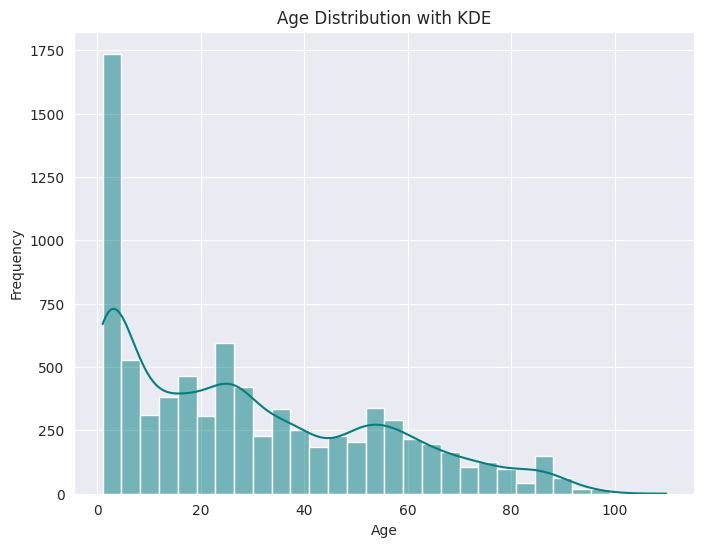

<Figure size 1000x800 with 0 Axes>

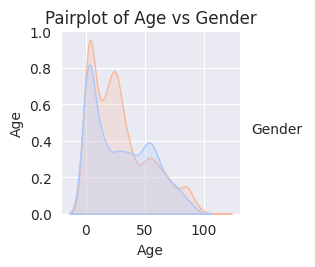

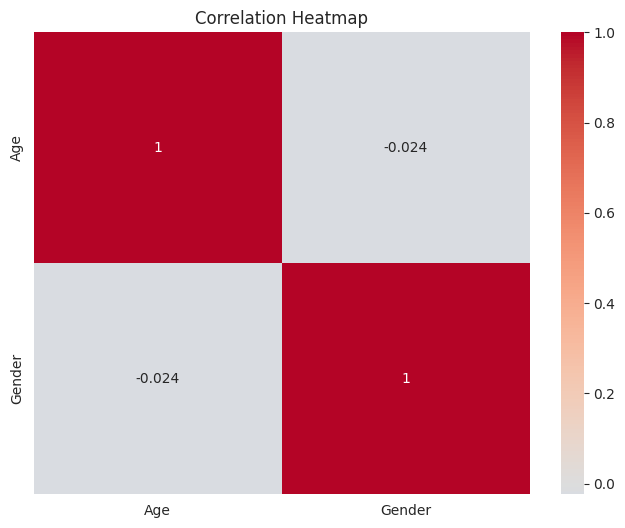

In [2]:
# Plot Gender Distribution with cool styling
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.countplot(x=genders, palette='pastel')
plt.title("Gender Distribution")
plt.xlabel("Gender (0 = Male, 1 = Female)")
plt.ylabel("Count")
plt.show()

# Age Group Distribution using cool palette
age_groups = pd.cut(ages, bins=[0, 18, 30, 50, 100], labels=["Under 18", "18-30", "31-50", "50+"], right=False)

plt.figure(figsize=(8, 6))
sns.countplot(x=age_groups, palette='coolwarm')
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

# Age vs Gender with cool scatter plot and regression line
plt.figure(figsize=(8, 6))
sns.regplot(x=ages, y=genders, scatter_kws={"s": 10}, line_kws={"color": "red"})
plt.title("Age vs Gender with Regression Line")
plt.xlabel("Age")
plt.ylabel("Gender (0 = Male, 1 = Female)")
plt.show()

# Additional Insights: Age Distribution with KDE using a cool color palette
plt.figure(figsize=(8, 6))
sns.histplot(ages, bins=30, kde=True, color='teal')
plt.title("Age Distribution with KDE")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Pairplot: Visualizing Age and Gender relationship
plt.figure(figsize=(10, 8))
sns.pairplot(df, hue="Gender", palette='coolwarm', markers=["o", "s"])
plt.title("Pairplot of Age vs Gender")
plt.show()

# Heatmap: Correlation Matrix of features (although we have few features, let's visualize them)
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

In [5]:
# Split data into training and test sets
X_train, X_test, y_gender_train, y_gender_test, y_age_train, y_age_test = train_test_split(
    images, genders, ages, test_size=0.2, random_state=42)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D

# 1. Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply data augmentation on training data
datagen.fit(X_train)

# 2. Model Configuration - Use EfficientNetB0 for feature extraction
base_model = EfficientNetB0(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model for fine-tuning later

# Model Inputs
inputs = Input(shape=(128, 128, 3))

# Base Model (EfficientNetB0)
X = base_model(inputs)
X = GlobalAveragePooling2D()(X)

# Fully Connected Layers
dense_1 = Dense(512, activation='relu')(X)
dropout_1 = Dropout(0.5)(dense_1)

# Gender Output: 1 unit, sigmoid activation for binary classification
output_1 = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)

# Age Output: 1 unit, linear activation for regression
output_2 = Dense(1, activation='relu', name='age_output')(dropout_1)

# Final model with two outputs
model = Model(inputs=inputs, outputs=[output_1, output_2])

# 3. Compile the Model with Early Stopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_squared_error'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})

# Print Model Summary
model.summary()




16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 efficientnetb0 (Functional  (None, 4, 4, 1280)           4049571   ['input_2[0][0]']             
 )                                                                                                
                                                                                                  
 global_average_pooling2d (  (None, 1280)                 0         ['efficientnetb0[0][0]']      
 GlobalAveragePooling2D)                                                                          
                             

In [7]:
# Train the model
history = model.fit(X_train,
                    {'gender_output': y_gender_train, 'age_output': y_age_train},  # Labels for both outputs
                    validation_data=(X_test, {'gender_output': y_gender_test, 'age_output': y_age_test}),  # Validation data for both outputs
                    epochs=15,  # Train for more epochs for better results
                    batch_size=128)

Epoch 1/15
50/50 [==============================] - 256s 5s/step - loss: 1156.8793 - gender_output_loss: 0.7733 - age_output_loss: 1156.1058 - gender_output_accuracy: 0.4908 - age_output_mae: 25.3256 - val_loss: 922.3024 - val_gender_output_loss: 0.7492 - val_age_output_loss: 921.5533 - val_gender_output_accuracy: 0.4319 - val_age_output_mae: 22.5750
Epoch 2/15
50/50 [==============================] - 244s 5s/step - loss: 770.7008 - gender_output_loss: 0.8936 - age_output_loss: 769.8073 - gender_output_accuracy: 0.4969 - age_output_mae: 21.3824 - val_loss: 681.2561 - val_gender_output_loss: 0.6839 - val_age_output_loss: 680.5722 - val_gender_output_accuracy: 0.5681 - val_age_output_mae: 20.7278
Epoch 3/15
50/50 [==============================] - 242s 5s/step - loss: 635.3185 - gender_output_loss: 1.0096 - age_output_loss: 634.3091 - gender_output_accuracy: 0.5086 - age_output_mae: 20.5538 - val_loss: 637.2703 - val_gender_output_loss: 0.6839 - val_age_output_loss: 636.5864 - val_gender

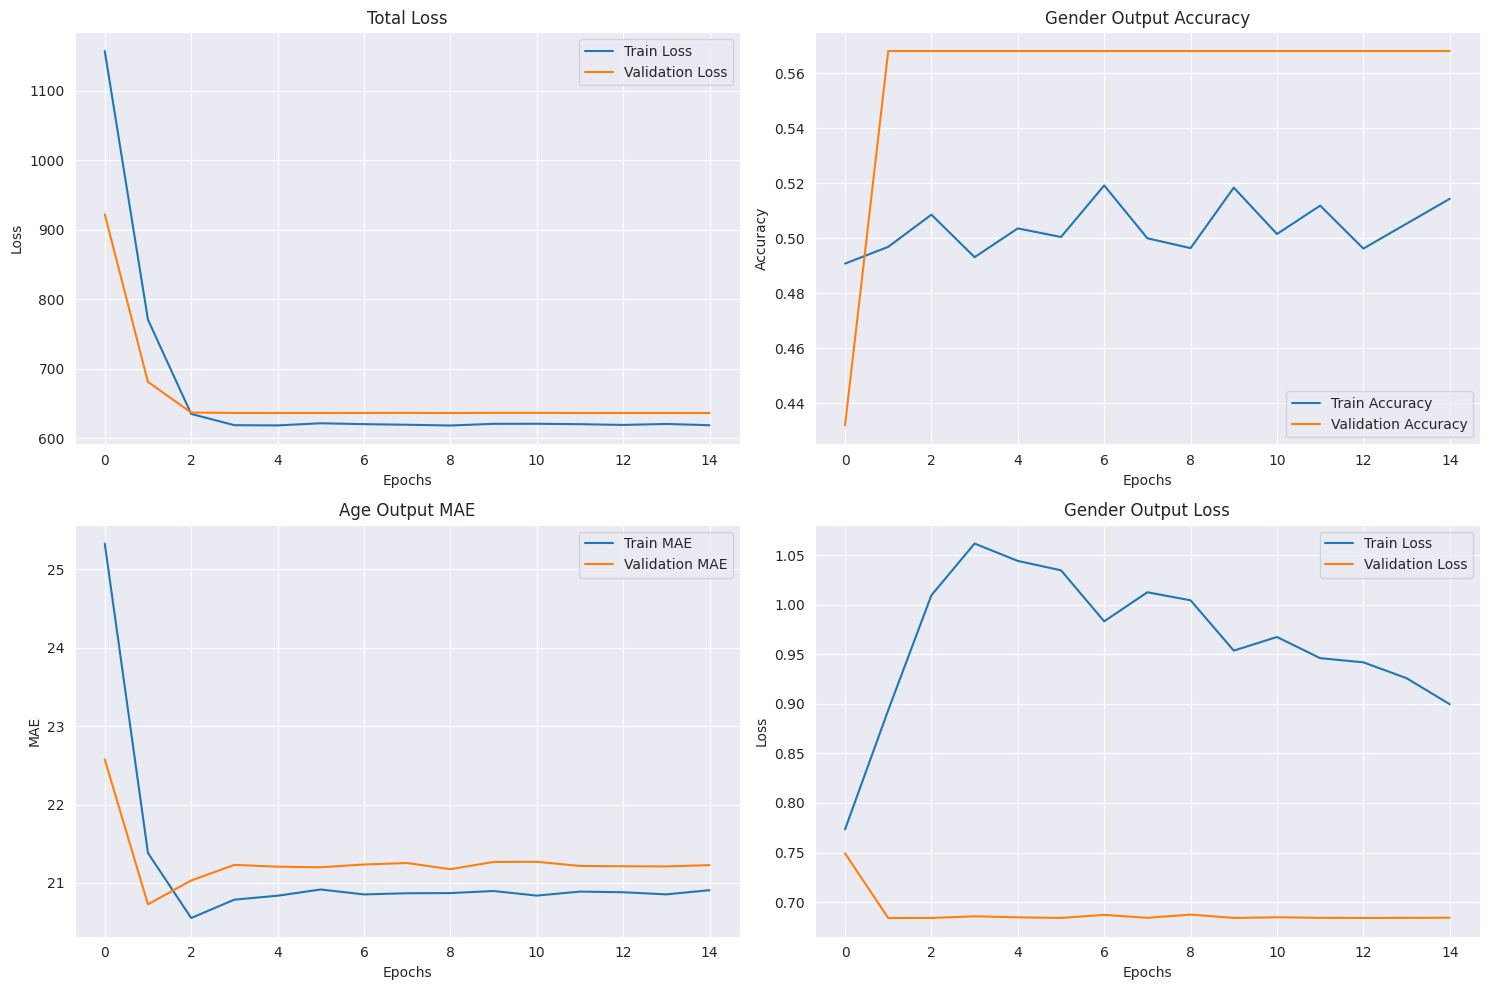

In [8]:
# Create a figure for all the graphs
plt.figure(figsize=(15, 10))

# Plotting training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gender Accuracy (Train and Validation)
plt.subplot(2, 2, 2)
plt.plot(history.history['gender_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='Validation Accuracy')
plt.title('Gender Output Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Age MAE (Mean Absolute Error) (Train and Validation)
plt.subplot(2, 2, 3)
plt.plot(history.history['age_output_mae'], label='Train MAE')
plt.plot(history.history['val_age_output_mae'], label='Validation MAE')
plt.title('Age Output MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Gender Loss (Train and Validation)
plt.subplot(2, 2, 4)
plt.plot(history.history['gender_output_loss'], label='Train Loss')
plt.plot(history.history['val_gender_output_loss'], label='Validation Loss')
plt.title('Gender Output Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display all the plots
plt.tight_layout()
plt.show()

In [12]:
# Model Evaluation (for test set)
results = model.evaluate(X_test,
                         {'gender_output': y_gender_test, 'age_output': y_age_test})

# Unpack the results
test_loss, gender_output_loss, age_output_loss, test_gender_accuracy, test_age_mae = results

# Print the evaluation results
print("Test Loss:", test_loss)
print("Gender Output Loss:", gender_output_loss)
print("Age Output Loss:", age_output_loss)
print("Test Gender Accuracy:", test_gender_accuracy)
print("Test Age MAE:", test_age_mae)

50/50 [==============================] - 45s 906ms/step - loss: 636.6162 - gender_output_loss: 0.6842 - age_output_loss: 635.9319 - gender_output_accuracy: 0.5681 - age_output_mae: 21.2274
Test Loss: 636.6162109375
Gender Output Loss: 0.6842218041419983
Age Output Loss: 635.9319458007812
Test Gender Accuracy: 0.5681250095367432
Test Age MAE: 21.227384567260742


In [13]:
print("Test Loss:", test_loss)
print("Test Gender Accuracy:", test_gender_accuracy)
print("Test Age MAE:", test_age_mae)


Test Loss: 636.6162109375
Test Gender Accuracy: 0.5681250095367432
Test Age MAE: 21.227384567260742


1/1 [==============================] - 0s 50ms/step


<ipython-input-14-5cfd7c1e9056>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Predicted Gender: {'Male' if gender_pred > 0.5 else 'Female'}, Predicted Age: {int(age_pred)}")


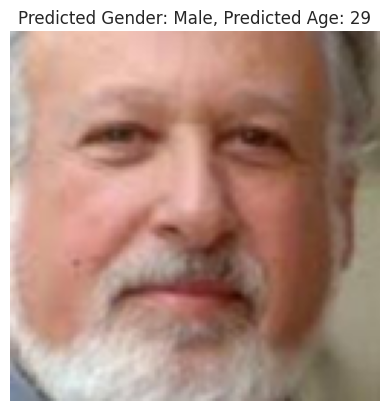

1/1 [==============================] - 0s 46ms/step


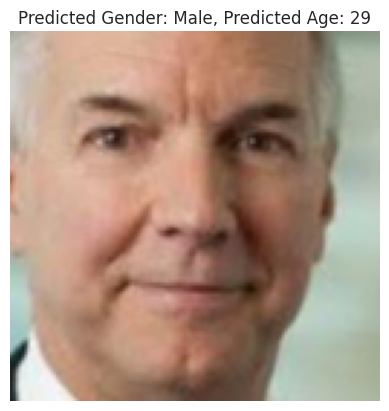

1/1 [==============================] - 0s 48ms/step


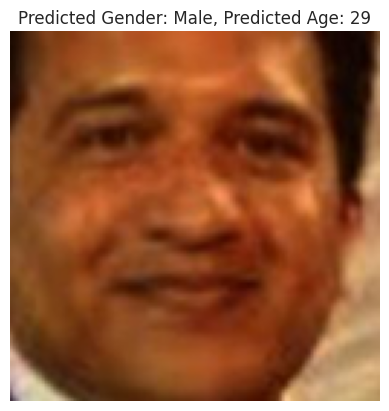

1/1 [==============================] - 0s 48ms/step


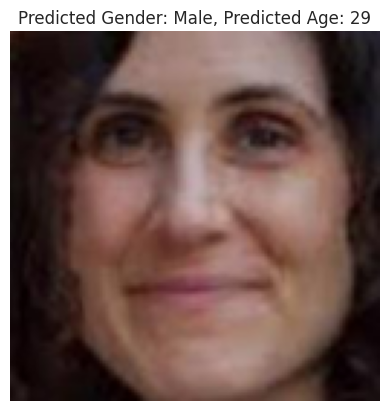

1/1 [==============================] - 0s 46ms/step


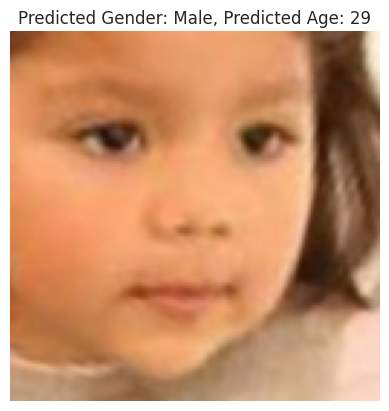

In [14]:
# Display some sample predictions
sample_idx = np.random.randint(0, len(X_test), 5)  # Random indices for sample display

for idx in sample_idx:
    img = X_test[idx] * 255.0  # Rescale back to [0, 255]
    img = np.clip(img, 0, 255).astype(np.uint8)
    img = Image.fromarray(img)

    gender_pred, age_pred = model.predict(np.expand_dims(X_test[idx], axis=0))

    plt.imshow(img)
    plt.title(f"Predicted Gender: {'Male' if gender_pred > 0.5 else 'Female'}, Predicted Age: {int(age_pred)}")
    plt.axis('off')
    plt.show()
